In [ ]:
from google.colab import drive

# Mount Google Drive with the option to allow full access
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


**Importing Required Libraries**

In [ ]:
import os  # For directory and file operations
import numpy as np  # For numerical operations and handling image arrays
import random  # For generating random values for augmentation
from PIL import Image, ImageEnhance  # For image processing and enhancement
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator  # For loading images
from tensorflow.keras.models import Sequential  # For building the model
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense  # For model layers
from tensorflow.keras.optimizers import Adam  # For optimizer
from tensorflow.keras.applications import VGG16,ResNet50  # For using VGG16 model
from sklearn.utils import shuffle  # For shuffling the data
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from tensorflow.keras.models import load_model
import numpy as np

**Loading and Shuffling Dataset**

In [ ]:
# Directories for training and testing data
train_dir = '/content/drive/MyDrive/MRI Images/Training/'
test_dir = '/content/drive/MyDrive/MRI Images/Testing/'

# Load and shuffle the train data
train_paths = []
train_labels = []
for label in os.listdir(train_dir):
    for image in os.listdir(os.path.join(train_dir, label)):
        train_paths.append(os.path.join(train_dir, label, image))
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

# Load and shuffle the test data
test_paths = []
test_labels = []
for label in os.listdir(test_dir):
    for image in os.listdir(os.path.join(test_dir, label)):
        test_paths.append(os.path.join(test_dir, label, image))
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

**Visualizing Sample Training Images**

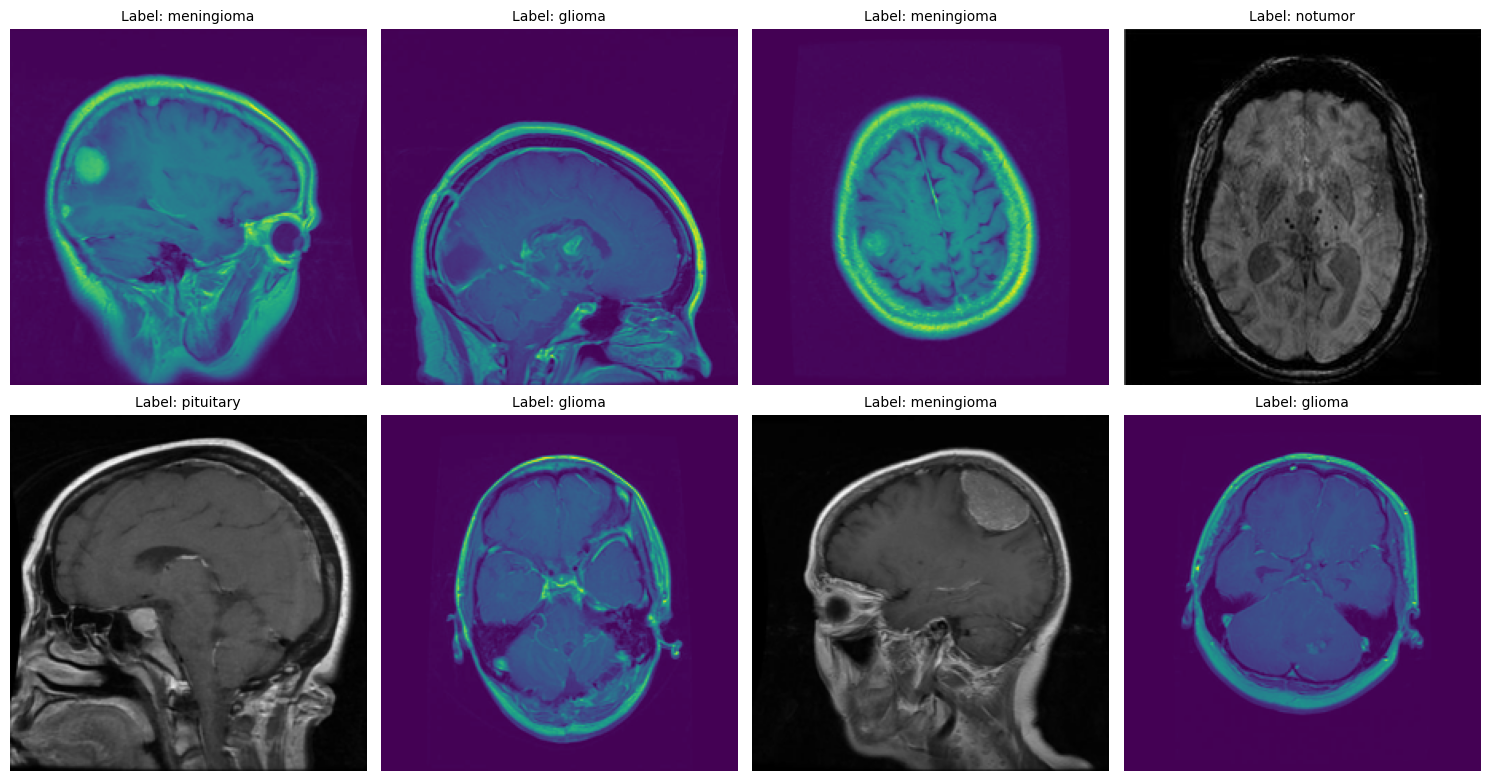

In [ ]:
import random
import matplotlib.pyplot as plt
from PIL import Image
import os

# Select random indices for 10 images
random_indices = random.sample(range(len(train_paths)), 8)

# Create a figure to display images in 2 rows
fig, axes = plt.subplots(2, 4, figsize=(15, 8))
axes = axes.ravel()

for i, idx in enumerate(random_indices):
    # Load image
    img_path = train_paths[idx]
    img = Image.open(img_path)
    img = img.resize((224, 224))  # Resize to consistent size

    # Display image
    axes[i].imshow(img)
    axes[i].axis('off')  # Hide axis
    # Display class label in the second row
    axes[i].set_title(f"Label: {train_labels[idx]}", fontsize=10)

plt.tight_layout()
plt.show()

**Data Preprocessing & Augmentation**


*   Loading
*   Augementing
*   Encoding images






In [ ]:
# Image Augmentation function
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))  # Random brightness
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))  # Random contrast
    image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
    return image
IMAGE_SIZE = 128
# Load images and apply augmentation
def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

# Encoding labels (convert label names to integers)
def encode_label(labels):
    unique_labels = os.listdir(train_dir)  # Ensure unique labels are determined
    encoded = [unique_labels.index(label) for label in labels]
    return np.array(encoded)

# Data generator for batching
def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_images = open_images(batch_paths)  # Open and augment images
            batch_labels = labels[i:i + batch_size]
            batch_labels = encode_label(batch_labels)  # Encode labels
            yield batch_images, batch_labels  # Yield the batch

**Model Creation, Training & Evaluation**

In [ ]:
def create_model(base_model_name, image_size=128):
    if base_model_name == "VGG16":
        base_model = VGG16(input_shape=(image_size, image_size, 3), include_top=False, weights='imagenet')
    elif base_model_name == "ResNet50":
        base_model = ResNet50(input_shape=(image_size, image_size, 3), include_top=False, weights='imagenet')
    else:
        raise ValueError("Invalid base model name. Choose 'VGG16' or 'ResNet50'.")

    # Freeze layers except last few
    for layer in base_model.layers[:-4]:
        layer.trainable = False

    # Define the final model
    model = Sequential([
        Input(shape=(image_size, image_size, 3)),
        base_model,
        Flatten(),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(len(os.listdir(train_dir)), activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])

    return model

models = {}
histories = {}

batch_size = 20  # You can adjust this value as needed
epochs = 10      # You can adjust this value as needed
steps = int(len(train_paths) / batch_size)  #

for model_name in ["VGG16", "ResNet50"]:
    print(f"\nTraining {model_name} model...\n")
    model = create_model(model_name)
    history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                        epochs=epochs, steps_per_epoch=steps)

    models[model_name] = model
    histories[model_name] = history





Training VGG16 model...

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
287/287 ━━━━━━━━━━━━━━━━━━━━ 1251s 4s/step - loss: 0.6651 - sparse_categorical_accuracy: 0.7312
Epoch 2/10
287/287 ━━━━━━━━━━━━━━━━━━━━ 36s 103ms/step - loss: 0.2669 - sparse_categorical_accuracy: 0.9054
Epoch 3/10
287/287 ━━━━━━━━━━━━━━━━━━━━ 30s 106ms/step - loss: 0.1915 - sparse_categorical_accuracy: 0.9296
Epoch 4/10
287/287 ━━━━━━━━━━━━━━━━━━━━ 30s 106ms/step - loss: 0.1180 - sparse_categorical_accuracy: 0.9587
Epoch 5/10
287/287 ━━━━━━━━━━━━━━━━━━━━ 30s 105ms/step - loss: 0.0904 - sparse_categorical_accuracy: 0.9664
Epoch 6/10
287/287 ━━━━━━━━━━━━━━━━━━━━ 30s 105ms/step - loss: 0.0855 - sparse_categorical_accuracy: 0.9673
Epoch 7/10
287/287 ━━━━━━━━━━━━━━━━━━━━ 31s 106ms/step - loss: 0.0661 - sparse_categorical_accuracy: 0.9764
Epoch 8/10
287/287 ━━━━━━━━━━━━━━━━━━━━ 30s 105ms/step - loss: 0.0539 - sparse_categorical_accuracy: 0.9823
Epoch 9/10
287/287 ━━━━━━━━━━━━━━━━━━━━ 30s 104ms/step - los

**Model Performance Comparison:**

* **Accuracy & Loss Trends**





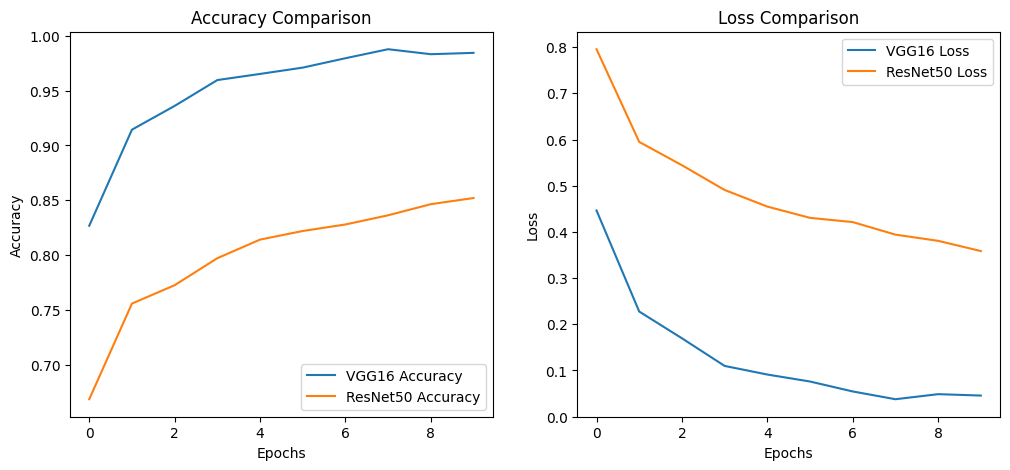

In [ ]:
plt.figure(figsize=(12, 5))

for i, model_name in enumerate(histories.keys()):
    history = histories[model_name]

    plt.subplot(1, 2, 1)
    plt.plot(history.history['sparse_categorical_accuracy'], label=f'{model_name} Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label=f'{model_name} Loss')

plt.subplot(1, 2, 1)
plt.title("Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()







*   **Performance Metrics & Visualization**





Evaluating VGG16 model...

41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 181ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       405
           1       0.96      0.96      0.96       300
           2       0.96      0.99      0.97       300
           3       0.96      0.92      0.94       306

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.97      0.97      0.97      1311



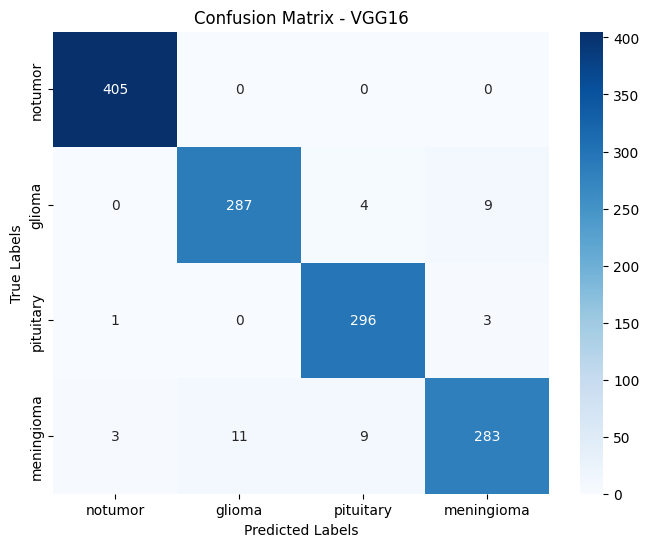


Evaluating ResNet50 model...

41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 149ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.98      0.91       405
           1       0.73      0.79      0.76       300
           2       0.94      0.85      0.90       300
           3       0.68      0.54      0.60       306

    accuracy                           0.80      1311
   macro avg       0.80      0.79      0.79      1311
weighted avg       0.80      0.80      0.80      1311



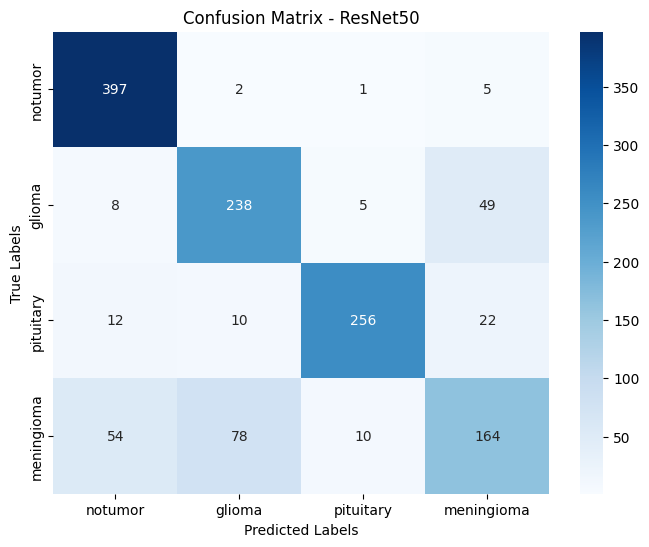

In [ ]:
for model_name, model in models.items():
    print(f"\nEvaluating {model_name} model...\n")

    test_images = open_images(test_paths)
    test_labels_encoded = encode_label(test_labels)

    test_predictions = model.predict(test_images)

    print("Classification Report:")
    print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))

    # Confusion Matrix
    conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()


* **Evaluating Classification Performance with ROC Curves**





41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


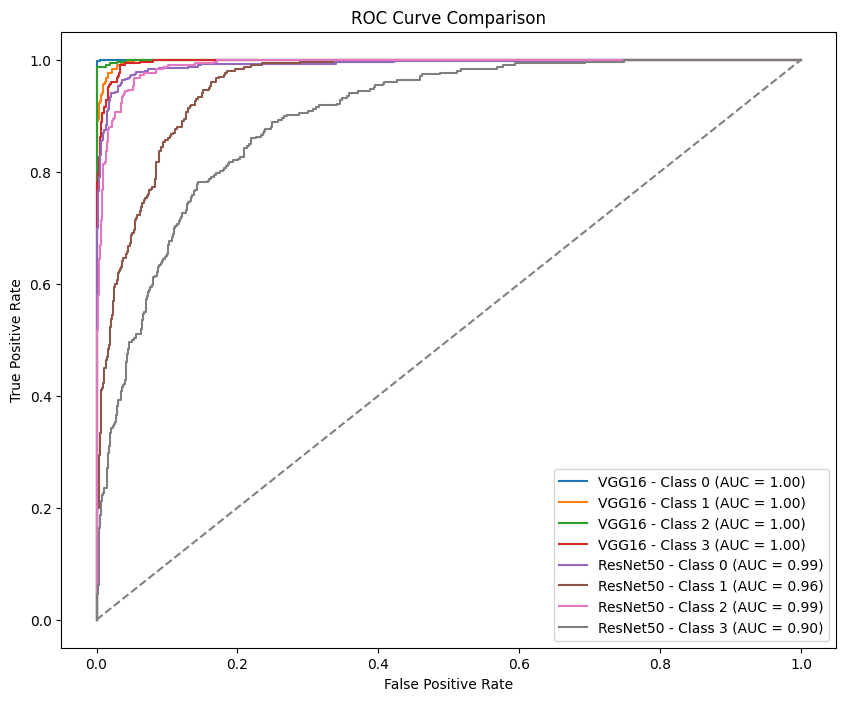

In [ ]:

from sklearn.preprocessing import label_binarize
import numpy as np
plt.figure(figsize=(10, 8))

for model_name, model in models.items():
    test_predictions_bin = model.predict(test_images)
    fpr, tpr, roc_auc = {}, {}, {}

    # Define test_labels_bin here, before using it in the loop
    # Assuming 'test_labels_encoded' and 'num_classes' are available
    # Replace num_classes with the actual number of classes if needed

    test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(os.listdir(train_dir))))

    for i in range(len(os.listdir(train_dir))):
        fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    for i in range(len(os.listdir(train_dir))):
        plt.plot(fpr[i], tpr[i], label=f'{model_name} - Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal reference line
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

